In [1]:
from transformers import OneFormerProcessor, OneFormerModel, TrainingArguments, Trainer
from PIL import Image
import requests
import torch

c:\Users\itsjo\anaconda3\envs\test_env\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\itsjo\anaconda3\envs\test_env\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\itsjo\anaconda3\envs\test_env\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\itsjo\anaconda3\envs\test_env\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# creare a OneFormer config
# initialize the model with the config
# train the model with a custom dataset -> Train class
# check model predictions

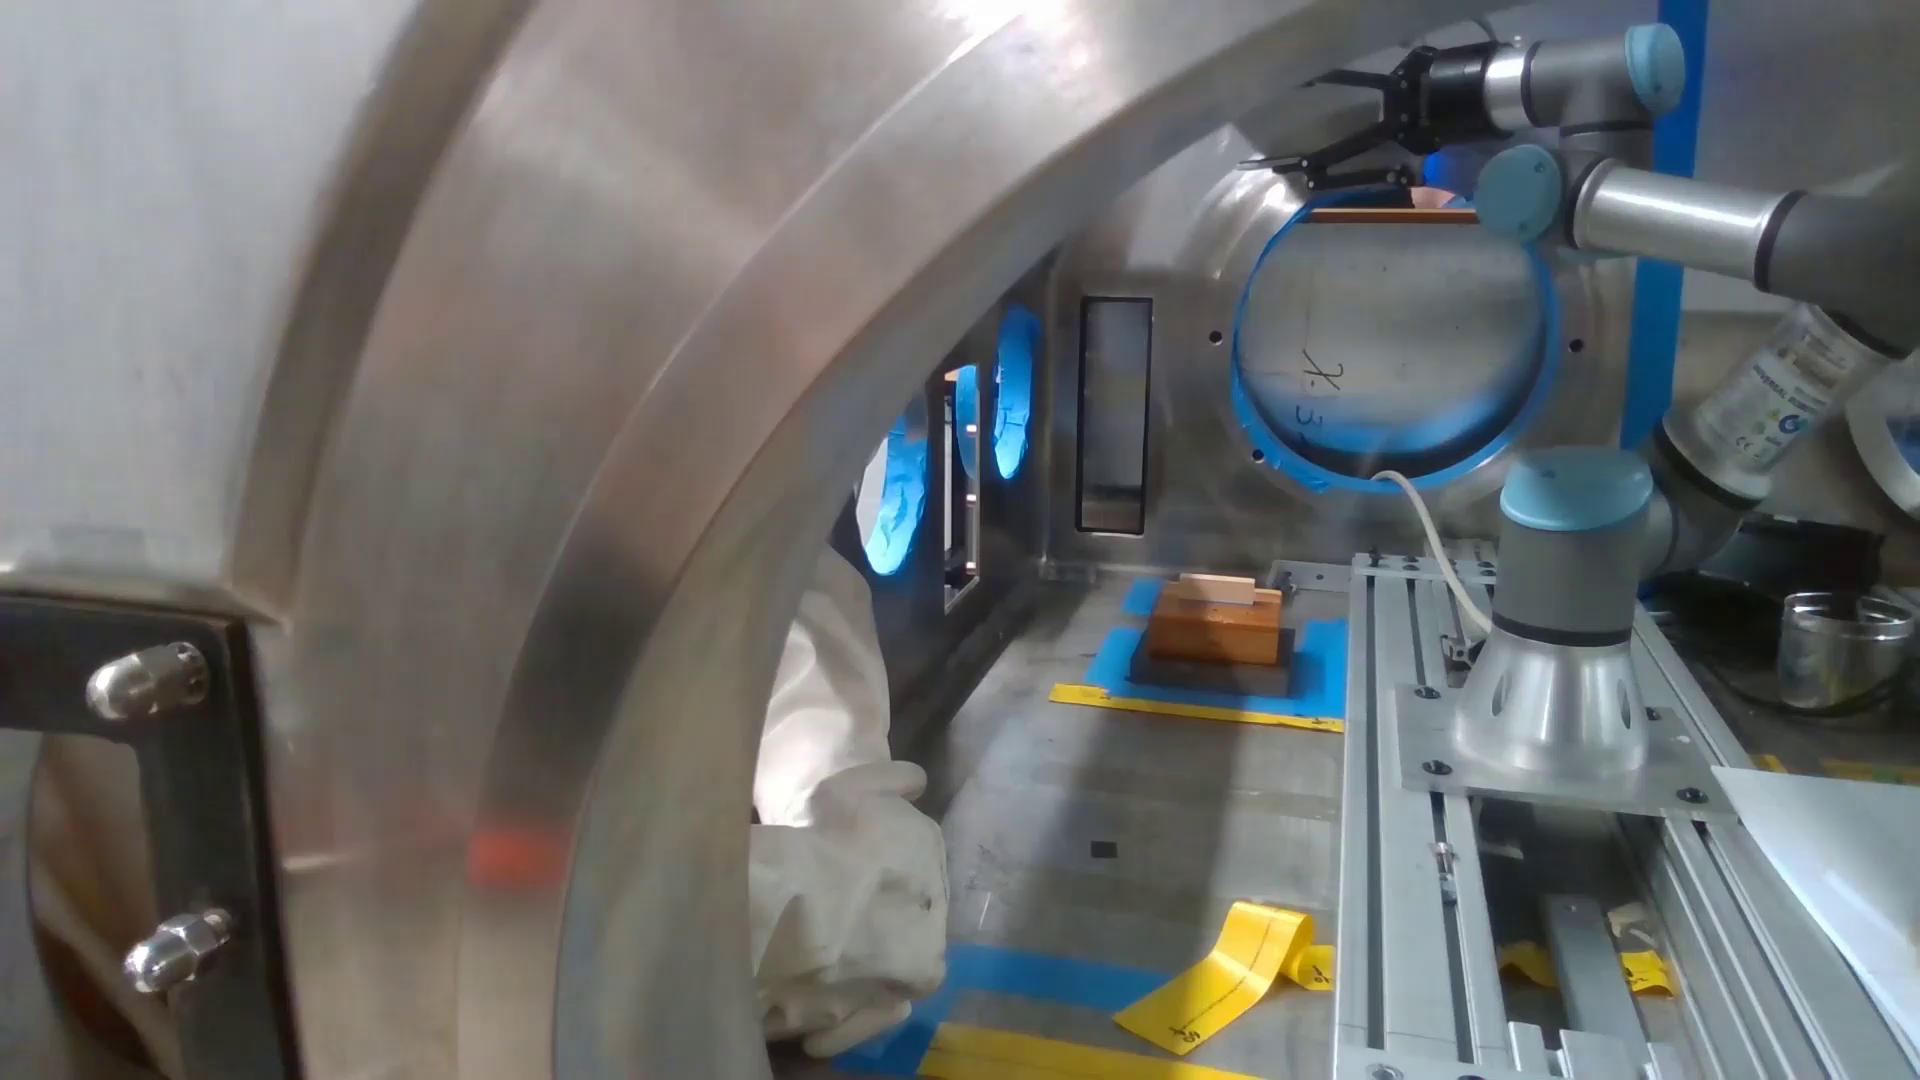

In [18]:
image = Image.open("J_GL_0.0.png")
image

In [4]:
processor = OneFormerProcessor.from_pretrained("shi-labs/oneformer_ade20k_swin_tiny")
model = OneFormerModel.from_pretrained("shi-labs/oneformer_ade20k_swin_tiny")

c:\Users\itsjo\anaconda3\envs\test_env\Lib\site-packages\transformers\models\oneformer\image_processing_oneformer.py:417: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(
Some weights of the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny were not used when initializing OneFormerModel: ['criterion.empty_weight', 'criterion.logit_scale']
- This IS expected if you are initializing OneFormerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OneFormerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
inputs = processor(image, ["semantic"], return_tensors="pt")

device = "cuda"
inputs = inputs.to(device)

with torch.no_grad():
    outputs = model(**inputs)

outputs

OneFormerModelOutput(encoder_hidden_states=(tensor([[[[ 7.6462e-01,  8.2933e-01,  7.3477e-01,  ...,  6.2511e-01,
            6.9750e-01, -4.2943e-01],
          [ 1.0200e+00,  1.0206e+00,  8.6019e-01,  ...,  8.1491e-01,
            8.4999e-01, -4.1176e-01],
          [ 7.5018e-01,  7.4987e-01,  7.2044e-01,  ...,  8.4360e-01,
            8.2655e-01, -5.6598e-01],
          ...,
          [ 6.2058e-01,  8.6173e-01,  7.1807e-01,  ...,  1.2497e-01,
            6.1171e-01,  2.2259e-01],
          [ 5.0626e-01,  5.9397e-01,  5.5017e-01,  ...,  8.7693e-01,
           -1.1346e+00,  9.1158e-01],
          [ 3.6587e-01,  6.9868e-01,  8.5438e-01,  ...,  1.1002e+00,
            9.6513e-01,  1.0013e+00]],

         [[ 3.0510e+00,  3.0479e+00,  3.0394e+00,  ...,  1.9264e+00,
            1.9802e+00,  1.7821e+00],
          [ 3.0202e+00,  3.0203e+00,  3.0270e+00,  ...,  1.9058e+00,
            1.9166e+00,  1.7037e+00],
          [ 2.9969e+00,  2.9970e+00,  3.0148e+00,  ...,  1.9096e+00,
            1.

In [22]:
import numpy as np
outputs.transformer_decoder_mask_predictions.shape, np.array(image).shape

(torch.Size([1, 150, 128, 228]), (1080, 1920, 3))

(128, 228)


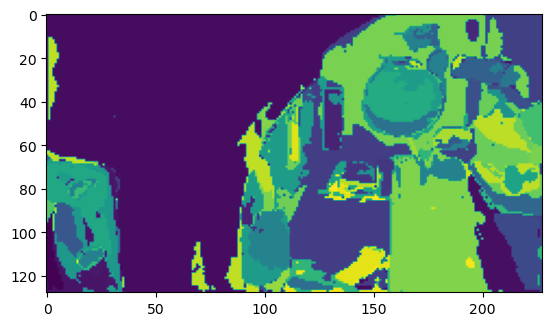

In [23]:
import matplotlib.pyplot as plt

mask_predictions = outputs.transformer_decoder_mask_predictions
# list(mask_predictions.shape)
# outputs.keys()

preds = torch.argmax(mask_predictions, dim=1)

img = preds[0].cpu().numpy()
print(img.shape)
plt.imshow(img)
plt.show()



# Now, Getting Oneformer to Work for Training

In [8]:
## use M and Y to switch cells b/w MD and python
## use ESC to move to command mode and Enter to go into edit mode
import torch
from torch.utils.data import Dataset, DataLoader
import sys
import os
# sys.path.append("..")
# print(os.getcwd())
# from dataloader import AssemblyDataset
from hf_dataloader import AssemblyDataset

dataset = AssemblyDataset(
    path_to_labels=['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View', 
                                          'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Top_View'], 
    path_to_images=['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View', 
                    'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Top_View']
                        )

dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)


In [9]:
import evaluate

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = torch.argmax(logits_tensor, dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()

        metrics = metric.compute(
            predictions = pred_labels,
            references = labels
        )

        return metrics

In [10]:

training_args = TrainingArguments(
    output_dir = "test-trainer",
    evaluation_strategy = "epoch",
    num_train_epochs = 3,
    max_steps = 3
)


In [11]:
trainer = Trainer(
    model=model,
    args = training_args,
    train_dataset = dataset,
    eval_dataset = dataset,
    compute_metrics = compute_metrics
)

In [12]:
from transformers import AdamW, get_scheduler

optimizer = AdamW(model.parameters(), lr=3e-5)

c:\Users\itsjo\anaconda3\envs\test_env\Lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
num_epochs = 3
num_training_steps = num_epochs * dataset.__len__()

In [14]:
lr_scheduler = get_scheduler(
        "linear",
        optimizer = optimizer,
        num_warmup_steps = 0,
        num_training_steps = num_training_steps,
)

In [15]:
from tqdm import tqdm
import torch.nn as nn
progress_bar = tqdm(range(num_training_steps))
device = "cuda"

model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
model.train()

for epoch in range(num_epochs):
    for index, batch in enumerate(dataloader):
        print(f"the index is {index}")
        x, y = batch
        inputs = processor(x, ["semantic"], return_tensors="pt")
        inputs = inputs.to(device)

        outputs = model(**inputs)
        
        loss_fn = nn.CrossEntropyLoss()
        y = y.to(device)

        print(f"ouputs is {outputs.transformer_decoder_mask_predictions.device}")
        print(f"y is {y.long().device}")

        loss = loss_fn(outputs.transformer_decoder_mask_predictions, y.long())
        
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        

  0%|          | 0/180 [00:00<?, ?it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

  1%|          | 1/180 [00:03<10:30,  3.52s/it]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

  1%|          | 2/180 [00:04<05:47,  1.95s/it]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

  2%|▏         | 3/180 [00:04<03:54,  1.32s/it]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

  2%|▏         | 4/180 [00:05<03:07,  1.07s/it]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

  3%|▎         | 5/180 [00:06<02:35,  1.13it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

  3%|▎         | 6/180 [00:06<02:15,  1.29it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

  4%|▍         | 7/180 [00:07<02:02,  1.41it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

  4%|▍         | 8/180 [00:07<01:57,  1.46it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

  5%|▌         | 9/180 [00:08<01:50,  1.55it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

  6%|▌         | 10/180 [00:09<01:48,  1.57it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

  6%|▌         | 11/180 [00:09<01:44,  1.61it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

  7%|▋         | 12/180 [00:10<01:42,  1.63it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

  7%|▋         | 13/180 [00:10<01:40,  1.66it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

  8%|▊         | 14/180 [00:11<01:40,  1.66it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

  8%|▊         | 15/180 [00:12<01:39,  1.66it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

  9%|▉         | 16/180 [00:12<01:42,  1.60it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

  9%|▉         | 17/180 [00:13<01:39,  1.63it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 10%|█         | 18/180 [00:13<01:38,  1.65it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 11%|█         | 19/180 [00:14<01:37,  1.66it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 11%|█         | 20/180 [00:15<01:36,  1.67it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 12%|█▏        | 21/180 [00:15<01:35,  1.67it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 12%|█▏        | 22/180 [00:16<01:33,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 13%|█▎        | 23/180 [00:16<01:32,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 13%|█▎        | 24/180 [00:17<01:31,  1.71it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 14%|█▍        | 25/180 [00:18<01:30,  1.71it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 14%|█▍        | 26/180 [00:18<01:30,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 15%|█▌        | 27/180 [00:19<01:29,  1.71it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 16%|█▌        | 28/180 [00:19<01:30,  1.67it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 16%|█▌        | 29/180 [00:20<01:29,  1.68it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 17%|█▋        | 30/180 [00:21<01:28,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 17%|█▋        | 31/180 [00:21<01:27,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 18%|█▊        | 32/180 [00:22<01:27,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 18%|█▊        | 33/180 [00:22<01:27,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 19%|█▉        | 34/180 [00:23<01:27,  1.67it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 19%|█▉        | 35/180 [00:23<01:26,  1.68it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 20%|██        | 36/180 [00:24<01:25,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 21%|██        | 37/180 [00:25<01:24,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 21%|██        | 38/180 [00:25<01:23,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 22%|██▏       | 39/180 [00:26<01:23,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 22%|██▏       | 40/180 [00:26<01:21,  1.72it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 23%|██▎       | 41/180 [00:27<01:21,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 23%|██▎       | 42/180 [00:28<01:21,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 24%|██▍       | 43/180 [00:28<01:20,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 24%|██▍       | 44/180 [00:29<01:19,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 25%|██▌       | 45/180 [00:29<01:20,  1.68it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 26%|██▌       | 46/180 [00:30<01:19,  1.68it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 26%|██▌       | 47/180 [00:31<01:18,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 27%|██▋       | 48/180 [00:31<01:18,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 27%|██▋       | 49/180 [00:32<01:17,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 28%|██▊       | 50/180 [00:32<01:16,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 28%|██▊       | 51/180 [00:33<01:16,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 29%|██▉       | 52/180 [00:34<01:14,  1.71it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 29%|██▉       | 53/180 [00:34<01:14,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 30%|███       | 54/180 [00:35<01:14,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 31%|███       | 55/180 [00:35<01:12,  1.72it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 31%|███       | 56/180 [00:36<01:11,  1.73it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 32%|███▏      | 57/180 [00:36<01:11,  1.72it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 32%|███▏      | 58/180 [00:37<01:11,  1.71it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 33%|███▎      | 59/180 [00:38<01:11,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 33%|███▎      | 60/180 [00:38<01:10,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 34%|███▍      | 61/180 [00:39<01:09,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 34%|███▍      | 62/180 [00:39<01:09,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 35%|███▌      | 63/180 [00:40<01:08,  1.71it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 36%|███▌      | 64/180 [00:41<01:07,  1.72it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 36%|███▌      | 65/180 [00:41<01:06,  1.72it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 37%|███▋      | 66/180 [00:42<01:06,  1.71it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 37%|███▋      | 67/180 [00:42<01:06,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 38%|███▊      | 68/180 [00:43<01:05,  1.72it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 38%|███▊      | 69/180 [00:43<01:04,  1.72it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 39%|███▉      | 70/180 [00:44<01:03,  1.73it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 39%|███▉      | 71/180 [00:45<01:03,  1.71it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 40%|████      | 72/180 [00:45<01:02,  1.73it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 41%|████      | 73/180 [00:46<01:03,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 41%|████      | 74/180 [00:46<01:02,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 42%|████▏     | 75/180 [00:47<01:01,  1.71it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 42%|████▏     | 76/180 [00:48<01:00,  1.73it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 43%|████▎     | 77/180 [00:48<00:59,  1.73it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 43%|████▎     | 78/180 [00:49<00:59,  1.72it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 44%|████▍     | 79/180 [00:49<00:58,  1.74it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 44%|████▍     | 80/180 [00:50<00:57,  1.75it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 45%|████▌     | 81/180 [00:50<00:57,  1.74it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 46%|████▌     | 82/180 [00:51<00:56,  1.72it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 46%|████▌     | 83/180 [00:52<00:56,  1.71it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 47%|████▋     | 84/180 [00:52<00:55,  1.72it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 47%|████▋     | 85/180 [00:53<00:56,  1.67it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 48%|████▊     | 86/180 [00:53<00:55,  1.68it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 48%|████▊     | 87/180 [00:54<00:54,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 49%|████▉     | 88/180 [00:55<00:54,  1.68it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 49%|████▉     | 89/180 [00:55<00:54,  1.66it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 50%|█████     | 90/180 [00:56<00:53,  1.68it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 51%|█████     | 91/180 [00:56<00:53,  1.68it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 51%|█████     | 92/180 [00:57<00:52,  1.67it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 52%|█████▏    | 93/180 [00:58<00:51,  1.68it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 52%|█████▏    | 94/180 [00:58<00:51,  1.67it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 53%|█████▎    | 95/180 [00:59<00:50,  1.68it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 53%|█████▎    | 96/180 [00:59<00:50,  1.68it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 54%|█████▍    | 97/180 [01:00<00:50,  1.65it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 54%|█████▍    | 98/180 [01:01<00:52,  1.56it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 55%|█████▌    | 99/180 [01:01<00:51,  1.57it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 56%|█████▌    | 100/180 [01:02<00:50,  1.57it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 56%|█████▌    | 101/180 [01:03<00:48,  1.62it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 57%|█████▋    | 102/180 [01:03<00:46,  1.66it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 57%|█████▋    | 103/180 [01:04<00:45,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 58%|█████▊    | 104/180 [01:04<00:45,  1.66it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 58%|█████▊    | 105/180 [01:05<00:45,  1.66it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 59%|█████▉    | 106/180 [01:05<00:44,  1.65it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 59%|█████▉    | 107/180 [01:06<00:43,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 60%|██████    | 108/180 [01:07<00:42,  1.71it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 61%|██████    | 109/180 [01:07<00:41,  1.71it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 61%|██████    | 110/180 [01:08<00:40,  1.71it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 62%|██████▏   | 111/180 [01:08<00:40,  1.71it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 62%|██████▏   | 112/180 [01:09<00:39,  1.73it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 63%|██████▎   | 113/180 [01:10<00:38,  1.72it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 63%|██████▎   | 114/180 [01:10<00:38,  1.71it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 64%|██████▍   | 115/180 [01:11<00:37,  1.72it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 64%|██████▍   | 116/180 [01:11<00:37,  1.72it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 65%|██████▌   | 117/180 [01:12<00:37,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 66%|██████▌   | 118/180 [01:12<00:37,  1.67it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 66%|██████▌   | 119/180 [01:13<00:36,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 67%|██████▋   | 120/180 [01:14<00:35,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 67%|██████▋   | 121/180 [01:14<00:34,  1.72it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 68%|██████▊   | 122/180 [01:15<00:33,  1.71it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 68%|██████▊   | 123/180 [01:15<00:32,  1.75it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 69%|██████▉   | 124/180 [01:16<00:31,  1.76it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 69%|██████▉   | 125/180 [01:17<00:31,  1.74it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 70%|███████   | 126/180 [01:17<00:30,  1.76it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 71%|███████   | 127/180 [01:18<00:30,  1.73it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 71%|███████   | 128/180 [01:18<00:30,  1.72it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 72%|███████▏  | 129/180 [01:19<00:30,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 72%|███████▏  | 130/180 [01:19<00:29,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 73%|███████▎  | 131/180 [01:20<00:28,  1.71it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 73%|███████▎  | 132/180 [01:21<00:27,  1.74it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 74%|███████▍  | 133/180 [01:21<00:27,  1.73it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 74%|███████▍  | 134/180 [01:22<00:26,  1.73it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 75%|███████▌  | 135/180 [01:22<00:26,  1.72it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 76%|███████▌  | 136/180 [01:23<00:25,  1.71it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 76%|███████▌  | 137/180 [01:23<00:25,  1.72it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 77%|███████▋  | 138/180 [01:24<00:24,  1.72it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 77%|███████▋  | 139/180 [01:25<00:23,  1.72it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 78%|███████▊  | 140/180 [01:25<00:23,  1.68it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 78%|███████▊  | 141/180 [01:26<00:23,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 79%|███████▉  | 142/180 [01:26<00:22,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 79%|███████▉  | 143/180 [01:27<00:21,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 80%|████████  | 144/180 [01:28<00:20,  1.71it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 81%|████████  | 145/180 [01:28<00:20,  1.68it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 81%|████████  | 146/180 [01:29<00:20,  1.68it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 82%|████████▏ | 147/180 [01:29<00:19,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 82%|████████▏ | 148/180 [01:30<00:19,  1.67it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 83%|████████▎ | 149/180 [01:31<00:18,  1.67it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 83%|████████▎ | 150/180 [01:31<00:17,  1.70it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 84%|████████▍ | 151/180 [01:32<00:17,  1.68it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 84%|████████▍ | 152/180 [01:32<00:17,  1.61it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 85%|████████▌ | 153/180 [01:33<00:16,  1.62it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 86%|████████▌ | 154/180 [01:34<00:15,  1.63it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 86%|████████▌ | 155/180 [01:34<00:15,  1.63it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 87%|████████▋ | 156/180 [01:35<00:14,  1.62it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 87%|████████▋ | 157/180 [01:36<00:14,  1.60it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 88%|████████▊ | 158/180 [01:36<00:13,  1.64it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 88%|████████▊ | 159/180 [01:37<00:12,  1.67it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 89%|████████▉ | 160/180 [01:37<00:12,  1.65it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 89%|████████▉ | 161/180 [01:38<00:11,  1.65it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 90%|█████████ | 162/180 [01:39<00:10,  1.66it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 91%|█████████ | 163/180 [01:39<00:10,  1.66it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 91%|█████████ | 164/180 [01:40<00:09,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 92%|█████████▏| 165/180 [01:40<00:09,  1.62it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 92%|█████████▏| 166/180 [01:41<00:08,  1.63it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 93%|█████████▎| 167/180 [01:42<00:07,  1.63it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 93%|█████████▎| 168/180 [01:42<00:07,  1.58it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 94%|█████████▍| 169/180 [01:43<00:06,  1.63it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 94%|█████████▍| 170/180 [01:44<00:06,  1.59it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 95%|█████████▌| 171/180 [01:44<00:05,  1.63it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 96%|█████████▌| 172/180 [01:45<00:04,  1.65it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 96%|█████████▌| 173/180 [01:45<00:04,  1.63it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 97%|█████████▋| 174/180 [01:46<00:03,  1.65it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 97%|█████████▋| 175/180 [01:46<00:02,  1.67it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 98%|█████████▊| 176/180 [01:47<00:02,  1.67it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 98%|█████████▊| 177/180 [01:48<00:01,  1.69it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 99%|█████████▉| 178/180 [01:48<00:01,  1.66it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

 99%|█████████▉| 179/180 [01:49<00:00,  1.67it/s]

the images are ['C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_0.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1012.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1181.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1349.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1518.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_168.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\Test_Subject_1\\id\\J\\Side_View\\J_GL_1687.0.png', 'C:\\Users\\itsjo\\Documents\\repos\\assembly_glovebox_dataset\\data\\Labels\\

100%|██████████| 180/180 [01:49<00:00,  1.67it/s]

In [16]:
type(num_training_steps)

int

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 import tqdm                                                                                  │
│ ❱ 2 hi = tqdm(range(num_training_steps))                                                         │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: 'module' object is not callable